In [1]:
# Basic set of Python Data Analysis
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.width',180)
pd.set_option('display.max_colwidth', 20)

## for plot by matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
from cycler import cycler
import seaborn as sns

# for plot by matplotlib
sns.set(font="DejaVu Sans", font_scale=1.8,
        rc={'figure.figsize': (10, 10),
            'lines.markersize': 15,
            "animation.embed_limit": 100})
sns.mpl.rc("axes", prop_cycle
           =cycler('color', ['#E24A33', '#348ABD', '#988ED5',
                             '#777777', '#FBC15E', '#8EBA42',
                             '#FFB5B8']))
sns.set_style('darkgrid', {'axes.facecolor': "0.8"})

# for markers
marker = itertools.cycle(('o', 'v', '^', 'D', '+', 'X', '<', '>'))
colors = itertools.cycle(('#E24A33', '#348ABD', '#988ED5', '#777777',
                          '#FBC15E', '#8EBA42', '#FFB5B8'))

## don't show warning
import warnings
warnings.filterwarnings('ignore')

## for machine learning with scikit learn
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from sklearn import metrics

## for system
import glob
import os, sys
sys.path.append(os.path.expanduser("../../toolkits"))
import basicTools as bt
import Etranform as et
from mapTools import linear as mt

### for reload modules
from importlib import reload

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Parameters

In [2]:
## the data directory
datadir = os.path.realpath("../../data")

## the prefix and suffix for search 
filePref = f"{datadir}/" #"/MD-clst"
fileSuff = ".xtc"

## the input trajs
# trajs = [x.replace(filePref, "").replace(fileSuff, "") 
#          for x in sorted(glob.glob(f"{filePref}*{fileSuff}")) 
#          if '000' in x
#         ]
trajs = ["MD-clst050"]

## output information
print("Find ", len(trajs), " trajectories in ", datadir)

Find  1  trajectories in  /home/ghzuo/data/gromacs/data.NTL9/2hba/htSeed/cluster-450-step50/clust-gromos_0.75-gro/298


In [3]:
## set the feature
feature = "dist"  #dih

## The data per frames
skip = 5

### smooth
step    = 200
width   = 400
seg2vec = bt.segment.medoid

### similar metrix
similar = bt.dist.cosin

### evalute method
evalute = metrics.calinski_harabasz_score # et.evalute.cluster

# Input Data

In [4]:
Xlist = []
Elist = []
flist = []
for i in trajs:
    ### the structure data
    X = bt.feature.dih2X(f"{filePref}{i}-rama.xvg") if feature == "dih" \
        else bt.feature.dist2X(f"{filePref}{i}-CaDist.xvg") 
    Xlist.append(np.array(X.loc[1::skip, :].reset_index(drop=True)))

    ### read the energy
    eng = pd.DataFrame(np.loadtxt(f"{filePref}{i}-potential.xvg", comments=["@","#"],
                             dtype = {'names': ('time', 'energy'), 
                                     'formats': ('f', 'f')}))
    Elist.append(np.array(eng.loc[1::skip, 'energy']))
    
    ### base frequence in MHz
    ## 1000,000 for M and P, and 2 for even extension
    flist.append(500000*skip/eng.loc[len(eng)-1, "time"])

    

### output the data shape
dshape = pd.DataFrame({"Feature":[x.shape for x in Xlist], 
                        "Energy":[e.shape for e in Elist],
                        "Freq (MHz)": flist})
dshape.index = trajs
print("The shape of the input data is:")
dshape

The shape of input file is:  (100001, 704)
The shape of the input data is:


,Feature,Energy,Freq (MHz)
MD-clst050,"(20000, 703)","(20000,)",2.5


In [5]:
## Check the base unit of frequence
try:
    if dshape['Freq (MHz)'].nunique() != 1:
        raise
    ufreq = flist[0]
    print("The base units of trajectores is", ufreq)
except Exception:
    print("The units of trajectories are not same")

The base units of trajectores is 2.5


# Data Rescaling

In [6]:
## do FFT rescaling
efft = et.Efft(Xlist, Elist)

## set the mapping tool
xmap = mt.LinearRegress(efft, info=0)

## get the score
qmc = xmap.score(kmax=100)

## Multiple Correlation Coefficient

Text(11.700000000000001, 0.9795797161263892, '#2 (2.5 MHz)\nQMC = 1.00')

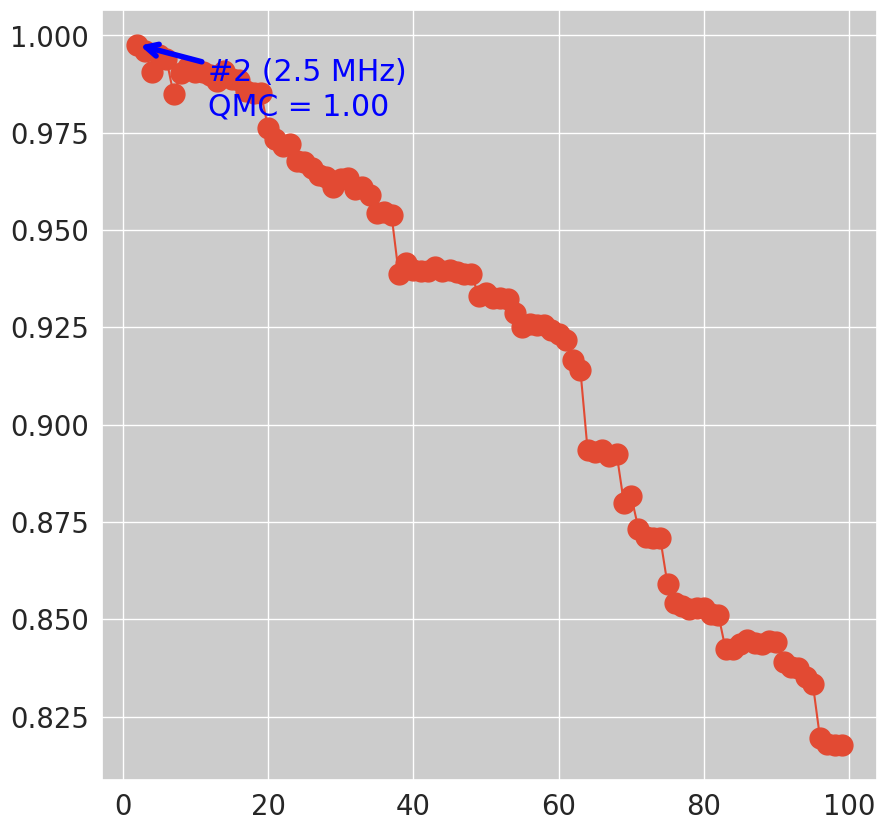

In [7]:
## plot the multiple correlation coefficient
plt.plot(qmc['list'][:,0],qmc['list'][:,1], marker="o")

## annotate the peak value
xy    = (qmc['KappaMax'], qmc['qmcMax'])
offset = 0.1 * (np.max(qmc['list'], axis=0)-np.min(qmc['list'],axis=0))
xytxt  = [xy[0] + offset[0], xy[1] - offset[1]]
plt.annotate("#{:d} ({:.1f} MHz)\nQMC = {:.2f}"
            .format(int(xy[0]), (xy[0]-1)*ufreq, xy[1]), 
            xy=xy, xytext=xytxt, color='blue', 
            arrowprops=dict(arrowstyle="->", color='blue', lw=4))

## Scaling for Selected Kappa

In [8]:
kappa = qmc['KappaMax']
rescl = xmap.scale(kappa)

## Weight of Features

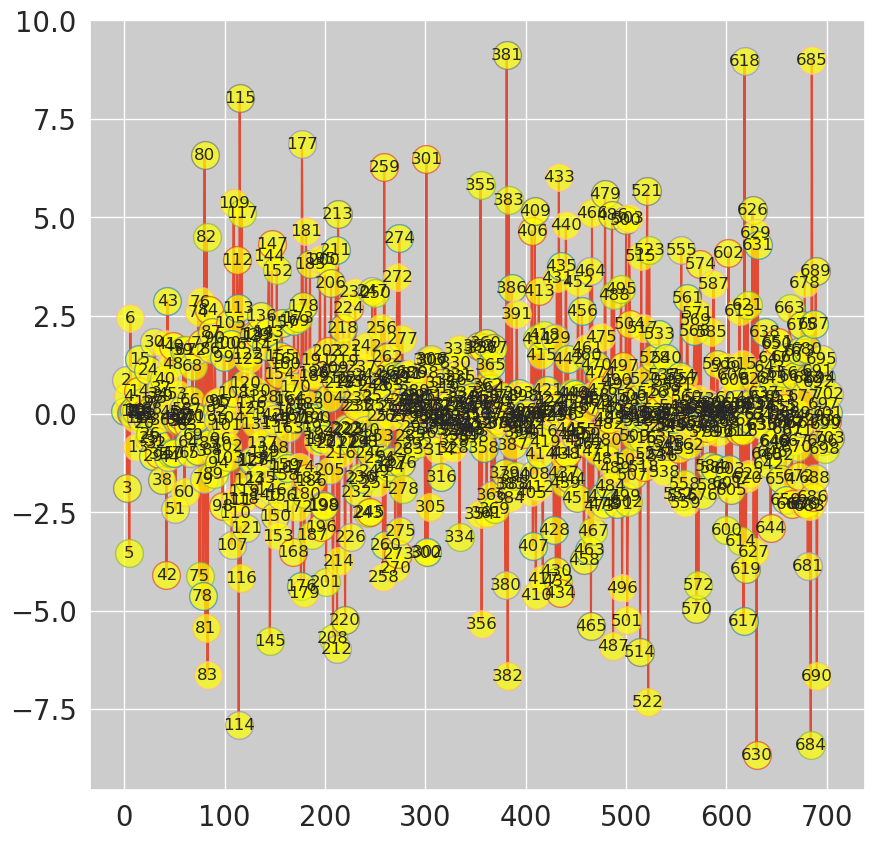

In [9]:
bt.plot.coefplot(bt.feature.dihCombind(rescl['A']) if feature == "dih" else rescl['A'])

## Distribution of Energy

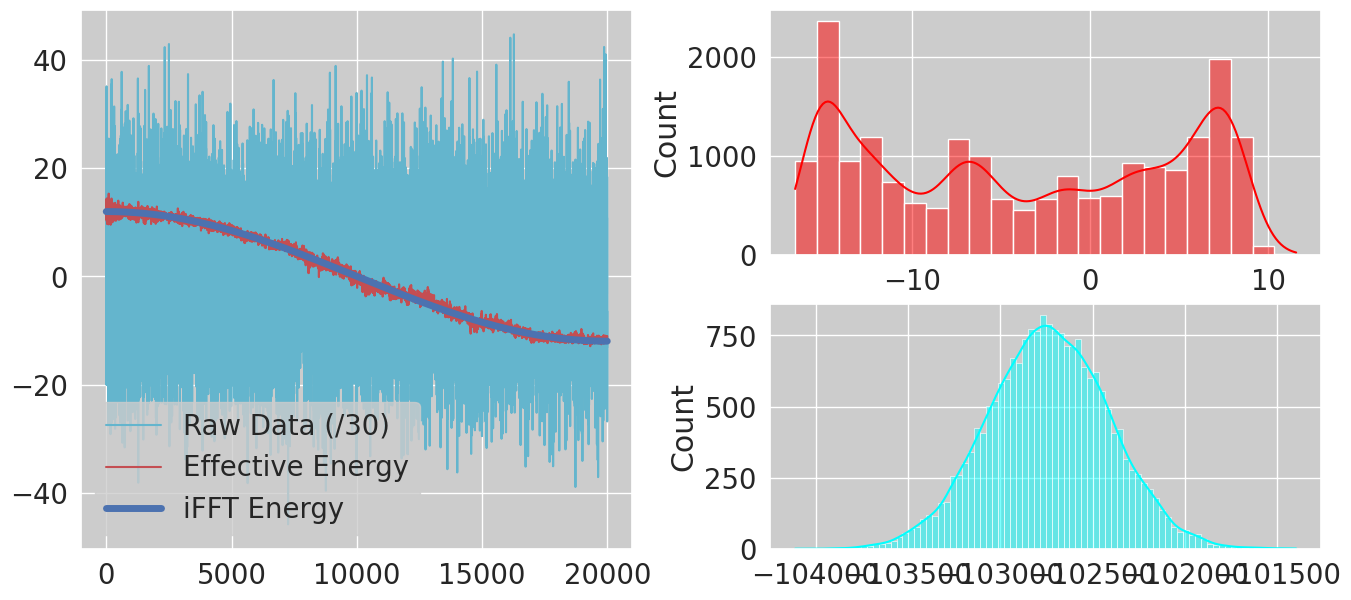

In [31]:
## plot the effective energy
bt.plot.efplot(np.concatenate(Elist), efft.Ef(kappa), np.concatenate(rescl['Ee']))

# Matrix Analysis

## Sample Data

In [11]:
## get the samples
Slist = []
for x in rescl['X']:
    Slist.append(seg2vec(x, step, width))
Xys = np.concatenate(Slist)

## Testing Similarity Matrix

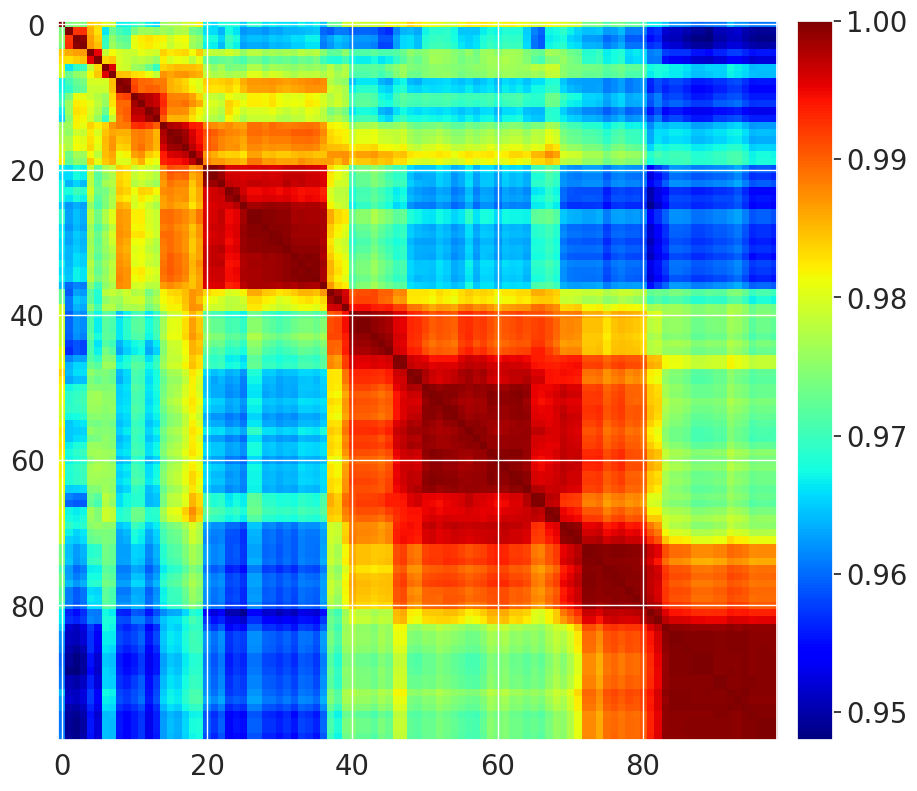

In [12]:
## set distance function and get distance
Smaty  = similar(Xys)
bt.plot.implot(Smaty)

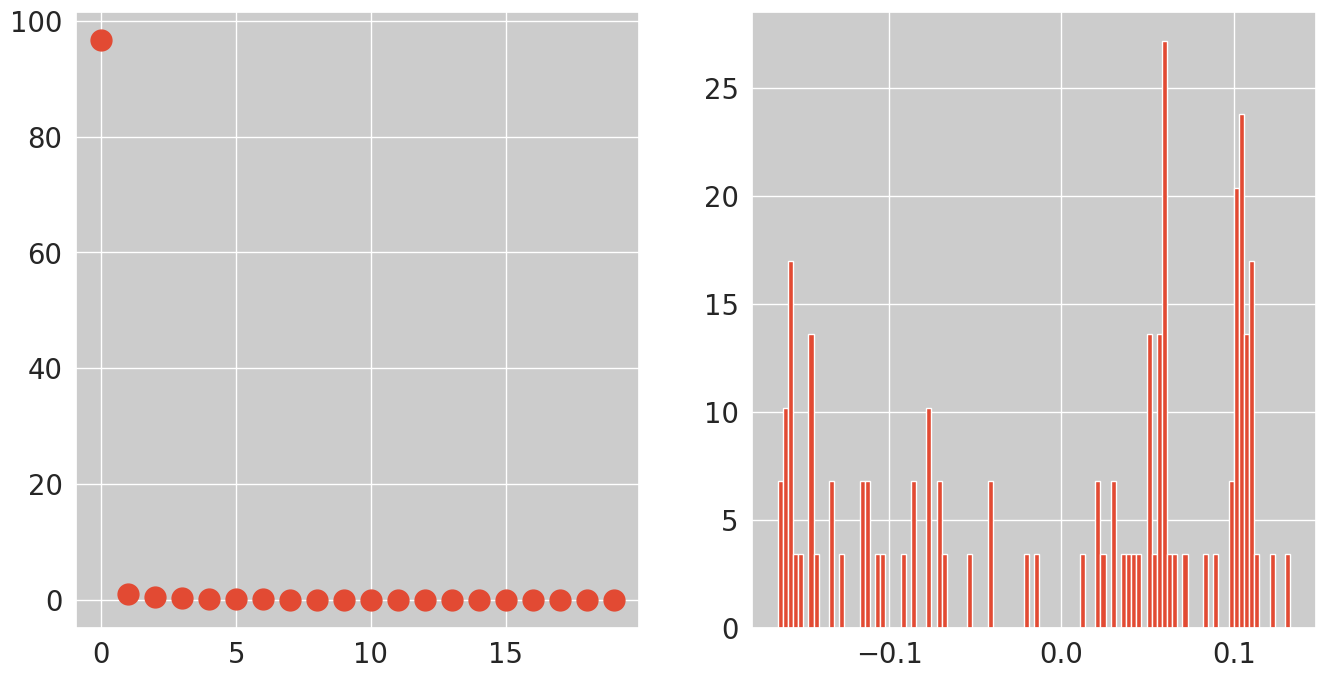

In [13]:
w,v = np.linalg.eig(Smaty)

fig, axs = plt.subplots(1,2, figsize=(16,8)) 
axs[0].plot(w[0:20], "o")
hist = axs[1].hist(v[:,1], bins=100, density=True)

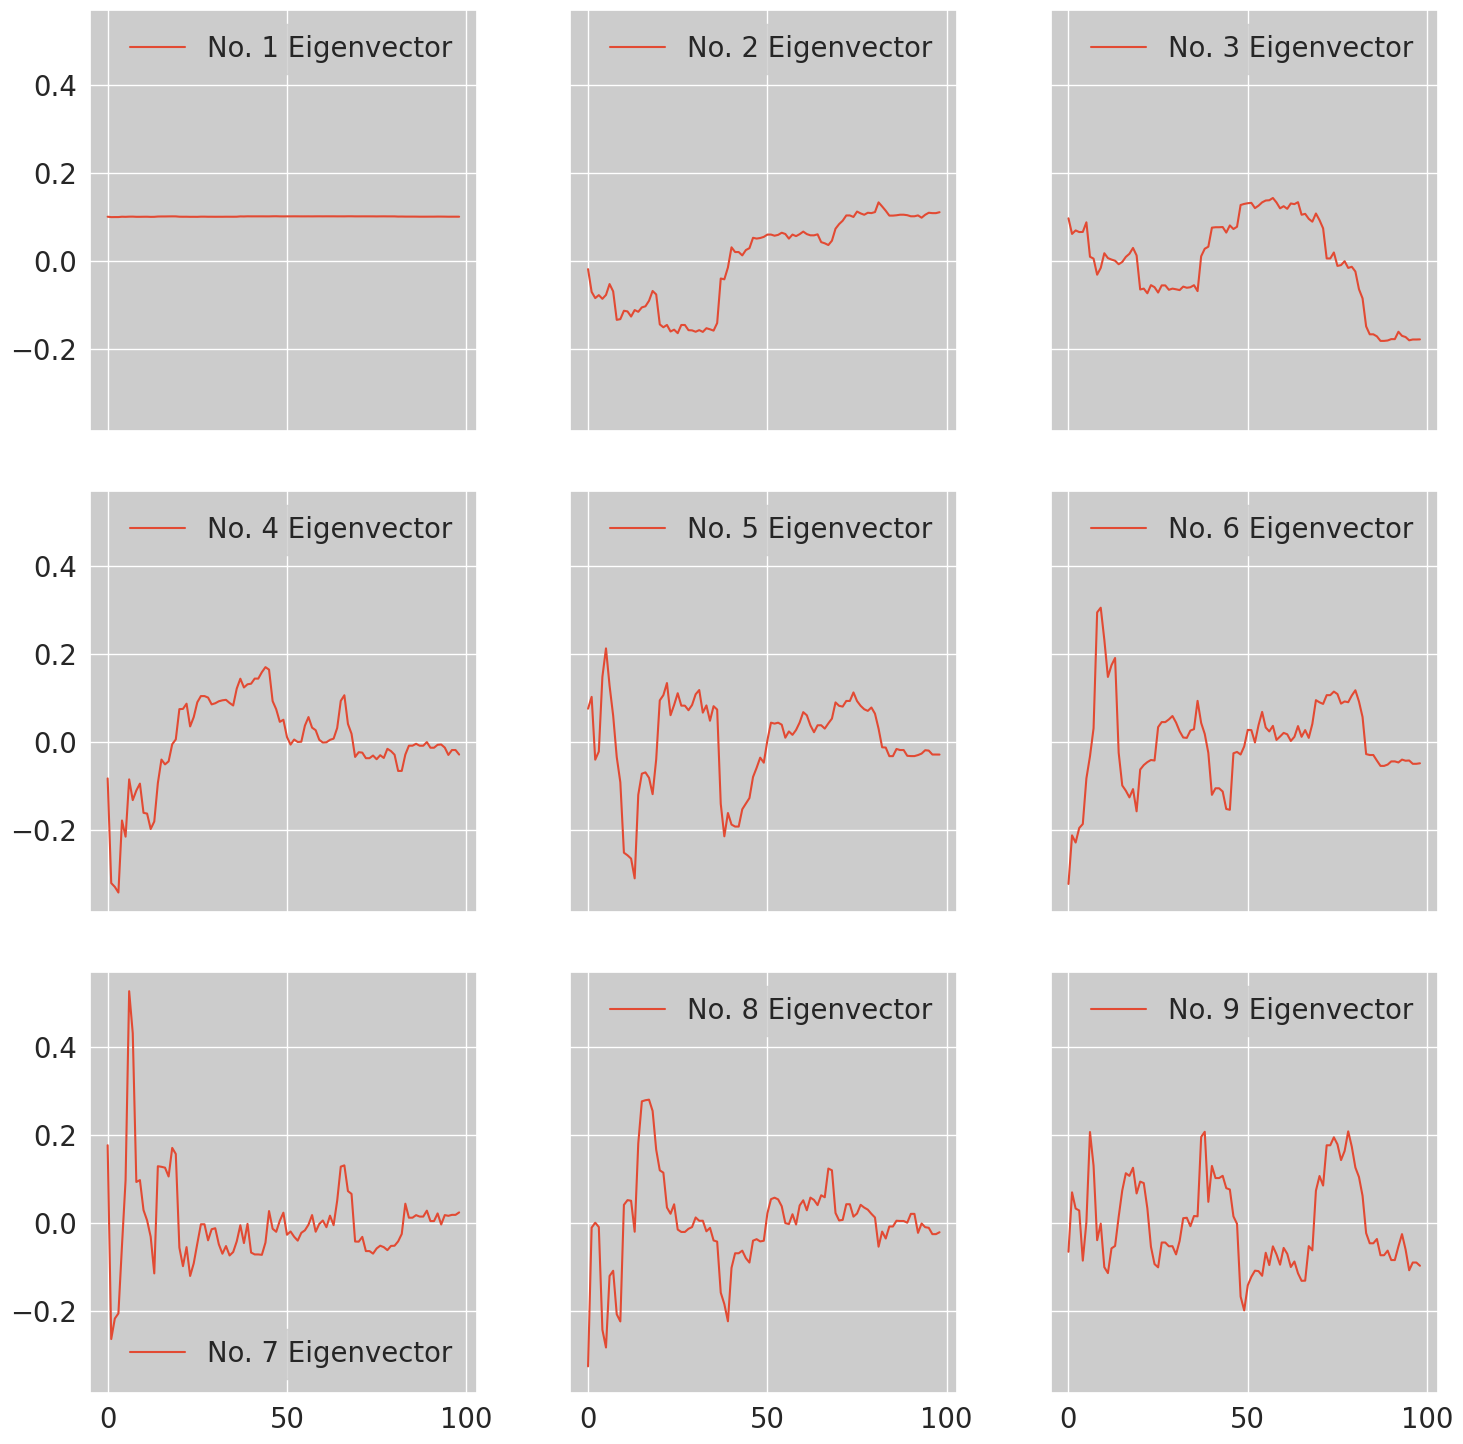

In [14]:
fig, axs = plt.subplots(3,3,sharex=True,sharey=True, figsize=(15,15)) 
sel = range(0,np.size(axs))
fig.tight_layout()
for ax, key in zip(axs.reshape(len(sel)), sel): 
    ax.plot(v[:,key])
    ax.legend(labels =["No. " + str(key+1) + " Eigenvector"])

## Testing Lapacian Matrix

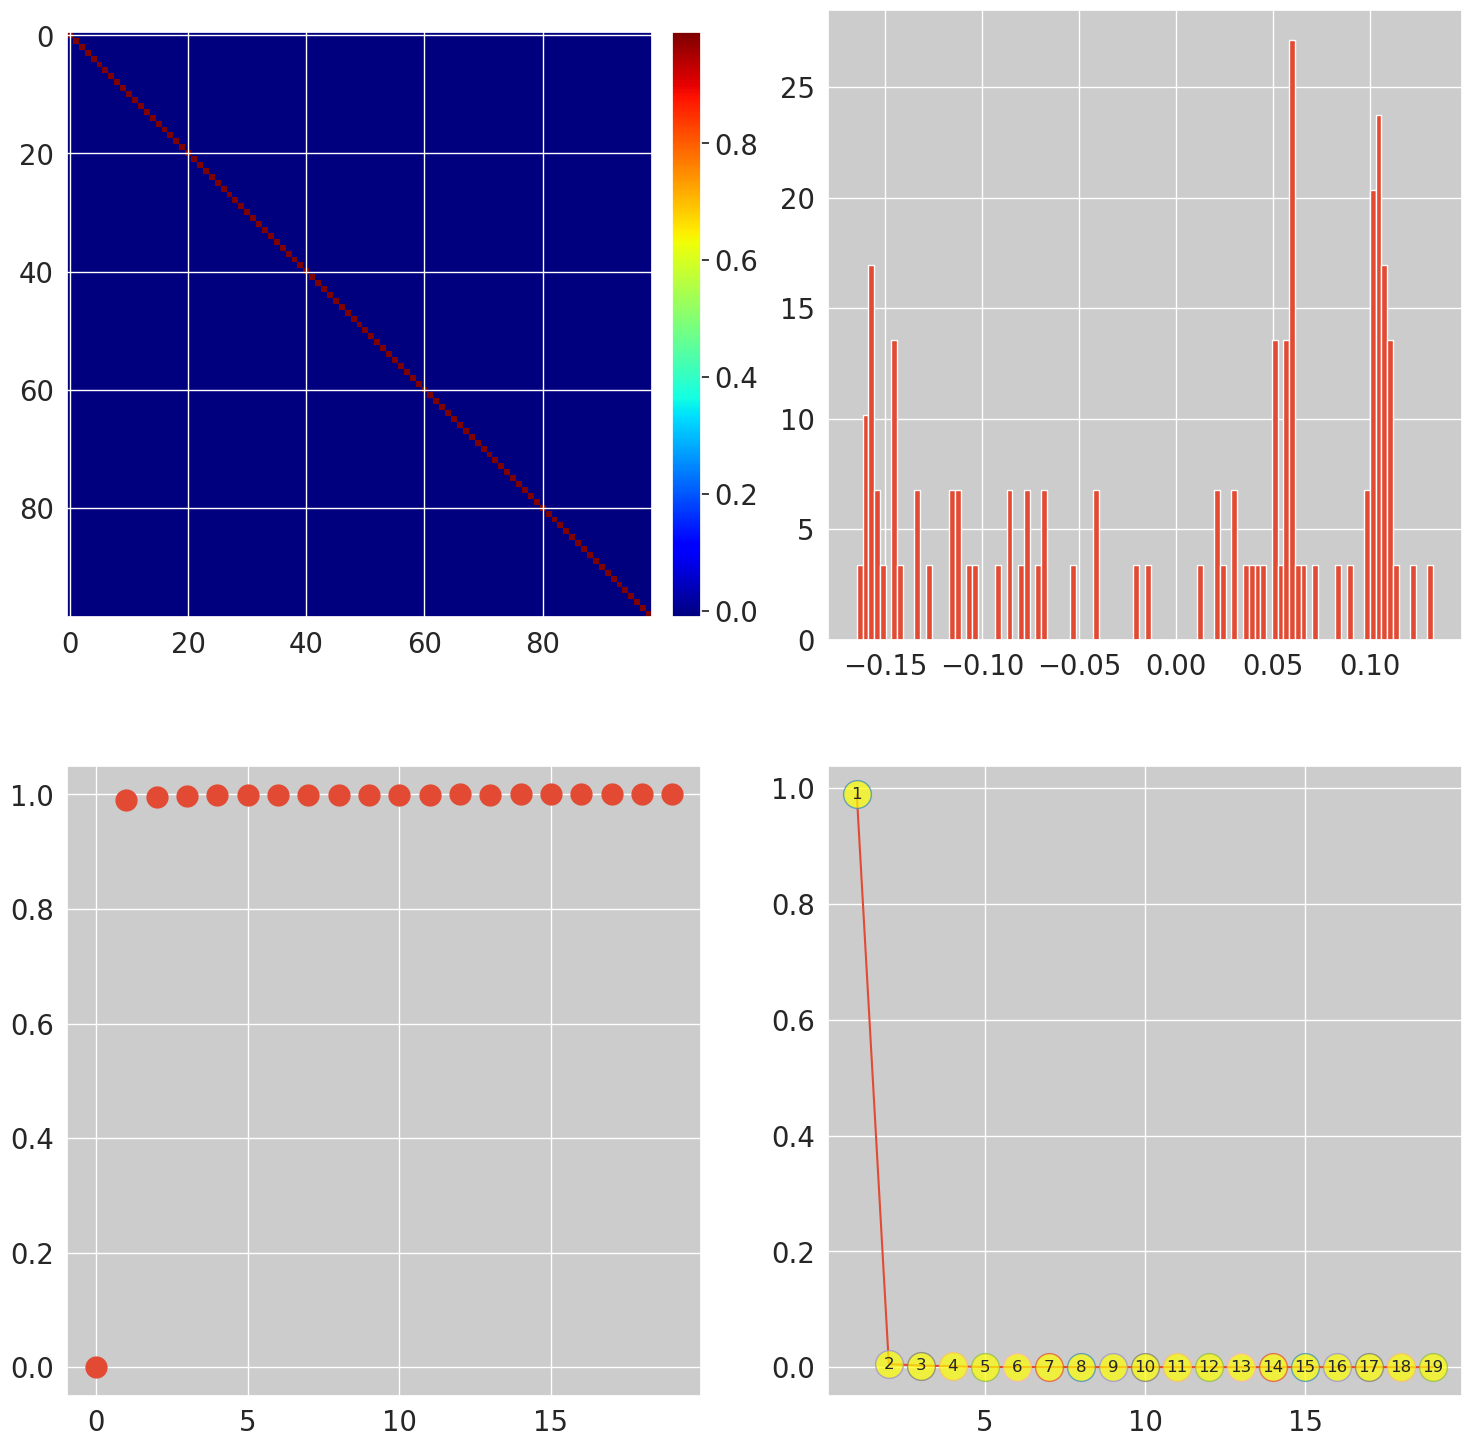

In [15]:
### Lapalacian Matrix
Nmat = bt.Lmat.NLmat_sym(Smaty)
w,v  = np.linalg.eig(Nmat)

## plot data
fig, axs = plt.subplots(2,2,figsize=(18,18)) 
bt.plot.implot(Nmat, axs[0,0])
hist = axs[0,1].hist(v[:,1], bins=100, density=True)
axs[1,0].plot(w[0:20], "o")
eg = w[1:20] - w[0:19]
bt.plot.coefplot(eg, axs[1,1])

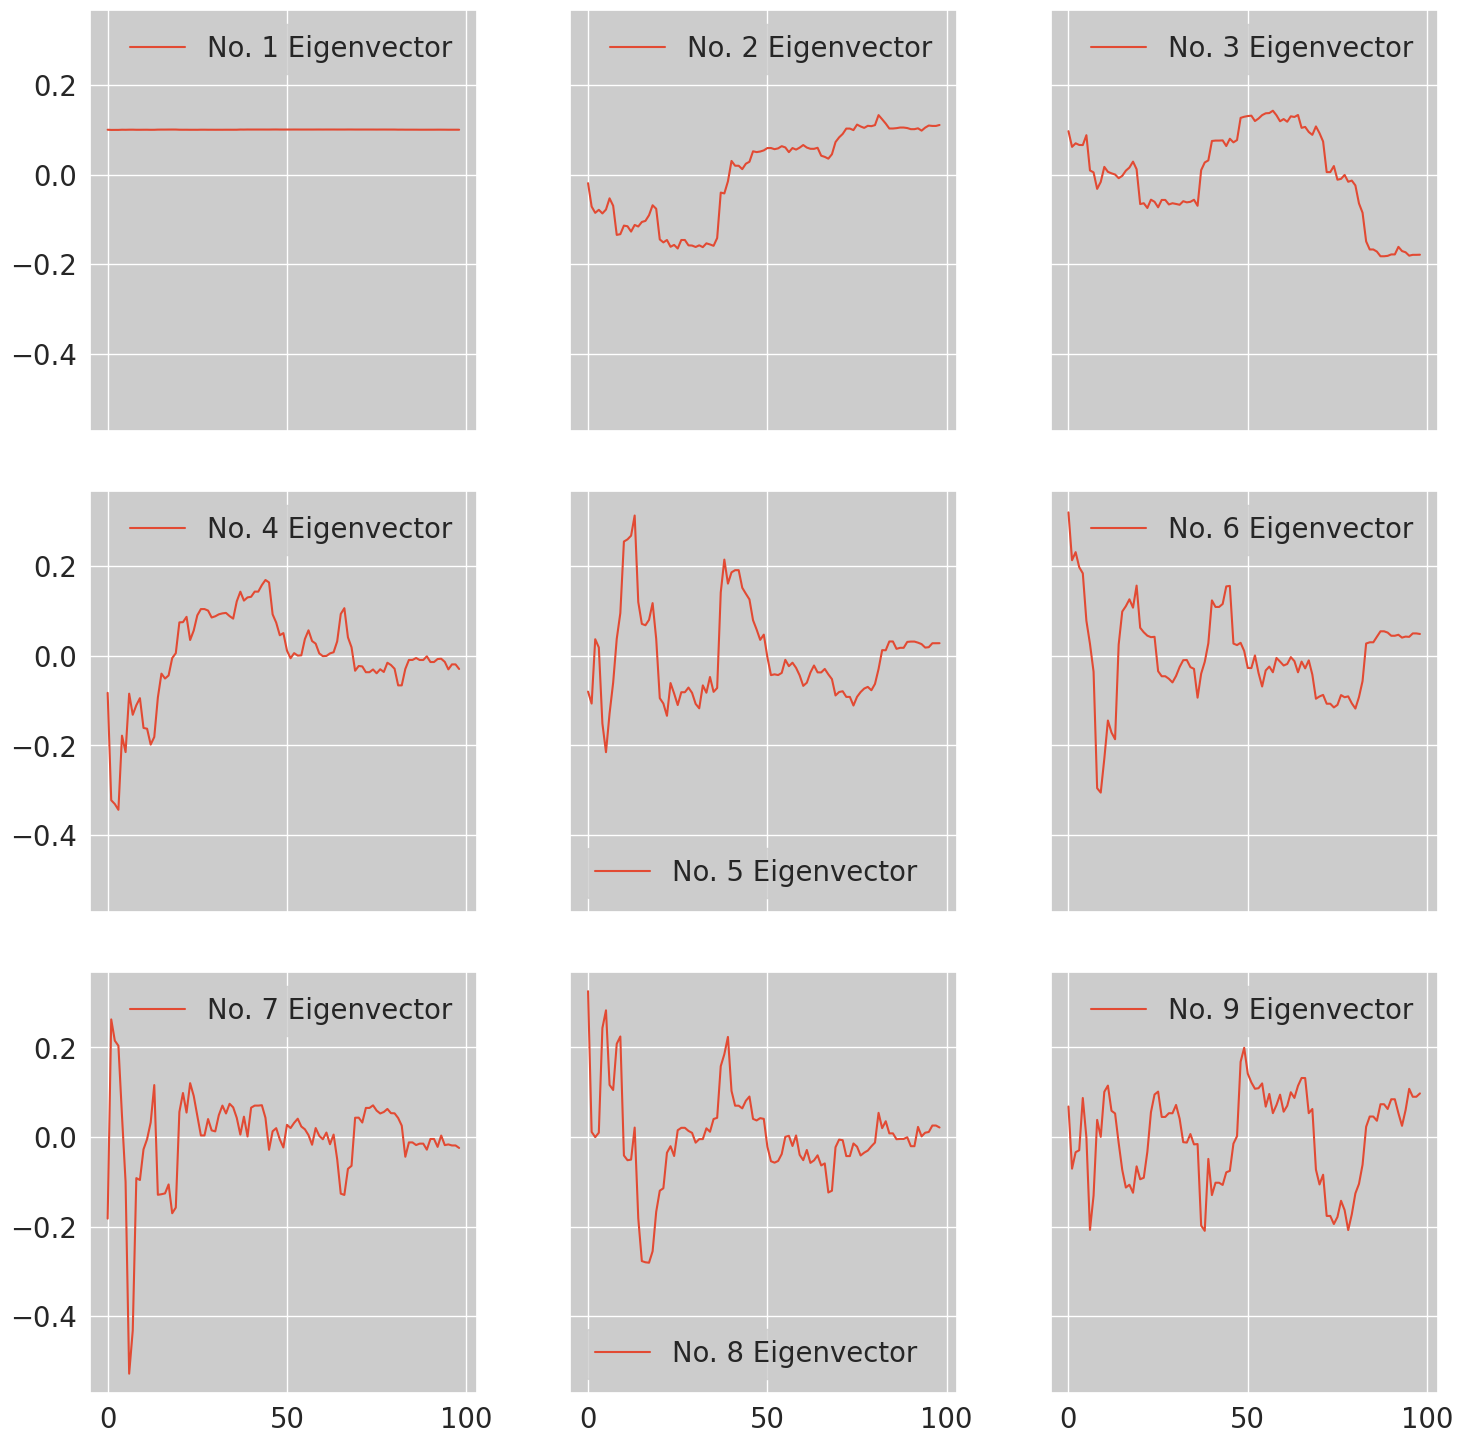

In [16]:
fig, axs = plt.subplots(3,3,sharex=True,sharey=True, figsize=(15,15)) 
sel = range(0,np.size(axs))
fig.tight_layout()
for ax, key in zip(axs.reshape(len(sel)), sel): 
    ax.plot(v[:,key])
    ax.legend(labels =["No. " + str(key+1) + " Eigenvector"])

# Clustering

## Clustering by Kmeans

In [17]:
## Test KMean parameters
def testKMn(n):
    cl = KMeans(n_clusters=n,n_init=50).fit_predict(Xys)
    return evalute(Xys, cl)

score_KMean = pd.DataFrame({'ncluster':np.arange(2,10)})
score_KMean['score'] = score_KMean['ncluster'].apply(testKMn)

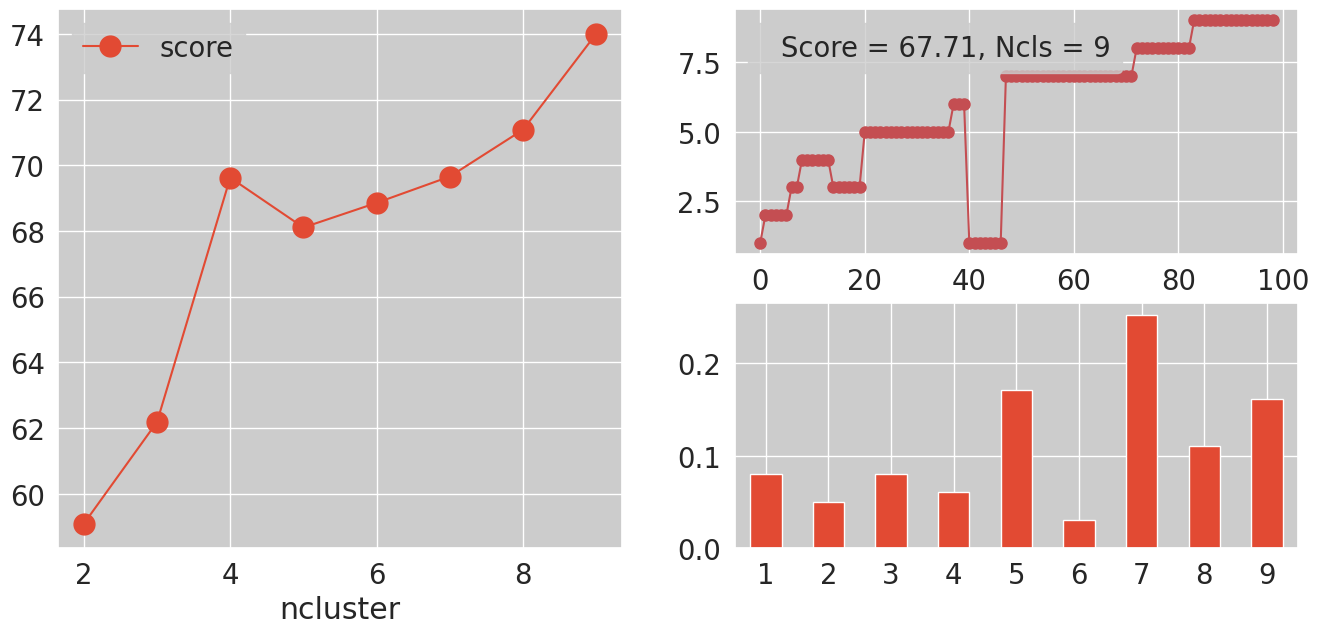

In [18]:
idxPeak = score_KMean['score'].idxmax();
ncls = score_KMean.loc[idxPeak,'ncluster']
cl   = KMeans(n_clusters=ncls).fit_predict(Xys)
lab  = "Score = {:.2f}, Ncls = {:d}".format(evalute (Xys, cl), ncls)

### plot data
bt.plot.clplot(score_KMean.set_index("ncluster"), cl, lab)

## Clustering by GMM

In [19]:
# Test KMean parameters
def testGMM(n):
    cl = GaussianMixture(n_components=n,n_init=50).fit_predict(Xys)
    return evalute(Xys, cl)

score_GMM = pd.DataFrame({'ncluster':np.arange(2,10)})
score_GMM['score'] = score_GMM['ncluster'].apply(testGMM)

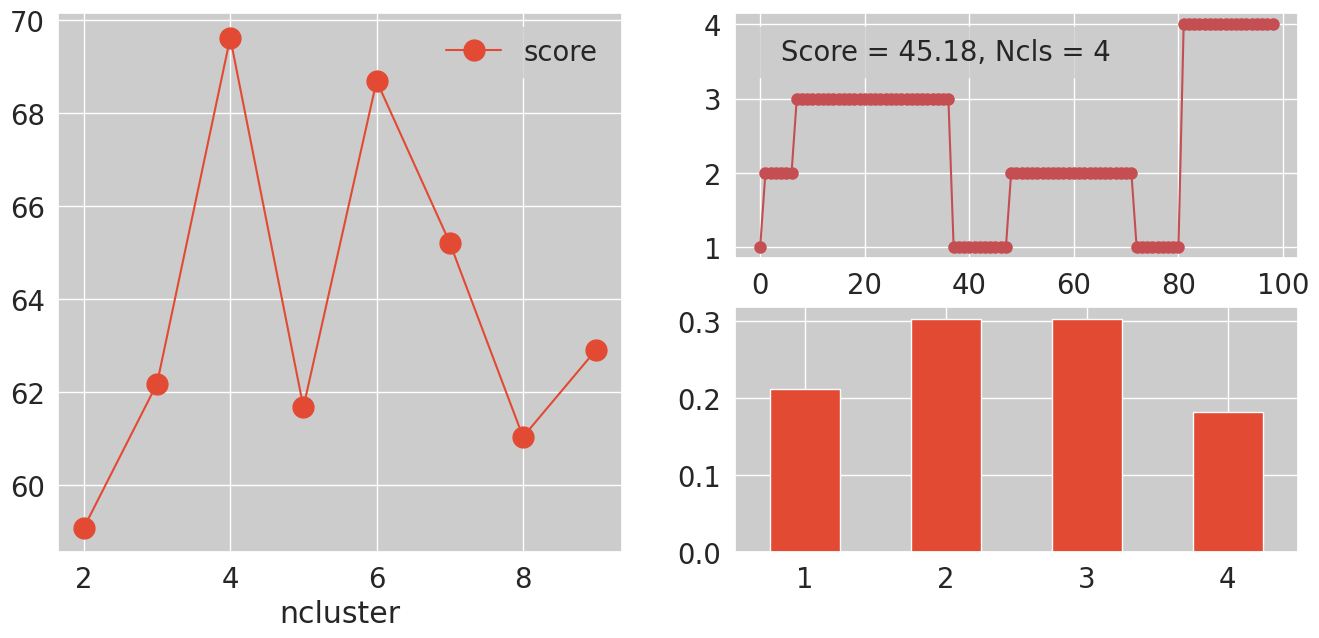

In [20]:
### find the top score parameter
idxPeak = score_GMM['score'].idxmax();
ncls = score_GMM.loc[idxPeak,'ncluster']
cl = GaussianMixture(n_components=ncls, n_init=50).fit_predict(Xys)
lab = "Score = {:.2f}, Ncls = {:d}".format(evalute(Xys, cl), ncls)

### plot data
bt.plot.clplot(score_GMM.set_index('ncluster'), cl, lab)

## Clustering by KMediods

### KMedoids by Matrix

In [21]:
## Testing Kmedoids by matrix
Dmat = 1.001 - Smaty
def testKMsm(n):
    cl = KMedoids(n_clusters=n, metric='precomputed').fit_predict(Dmat)
    return np.max(cl) > 0 and evalute(Xys, cl) or 0

### get the score
score_KMedoidsMat = pd.DataFrame({'ncluster':np.arange(2,10)})
score_KMedoidsMat['score'] = score_KMedoidsMat['ncluster'].apply(testKMsm)

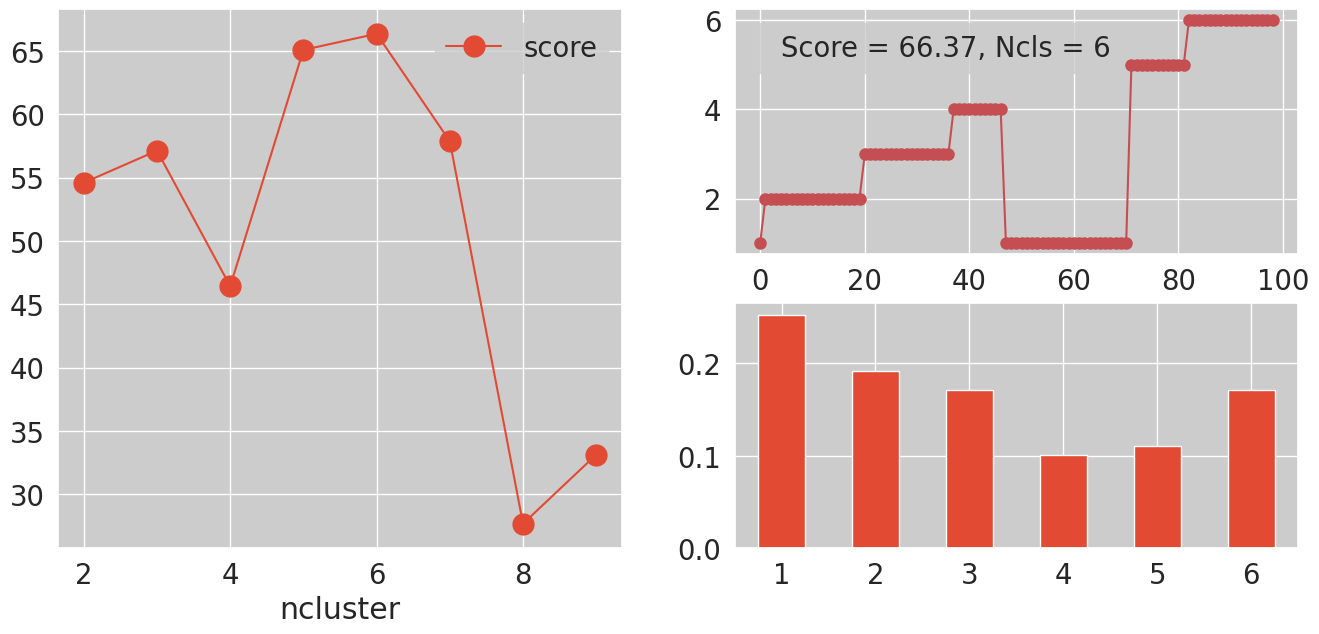

In [22]:
### find the top score parameter
idxPeak = score_KMedoidsMat['score'].idxmax();
ncls = score_KMedoidsMat.loc[idxPeak,'ncluster']
cl = KMedoids(n_clusters=ncls, metric='precomputed').fit_predict(Dmat)
lab  = "Score = {:.2f}, Ncls = {:d}".format(evalute (Xys, cl), ncls)

### plot data
bt.plot.clplot(score_KMedoidsMat.set_index("ncluster"), cl, lab)

### KMediods by Trajectory

In [23]:
## Testing Kmediods parameters by trajectory
def testKMs(n):
    cl = KMedoids(n_clusters=n).fit_predict(Xys)
    return np.max(cl) > 0 and evalute(Xys, cl) or 0

score_KMediods = pd.DataFrame({'ncluster':np.arange(2,10)})
score_KMediods['score'] = score_KMediods['ncluster'].apply(testKMs)

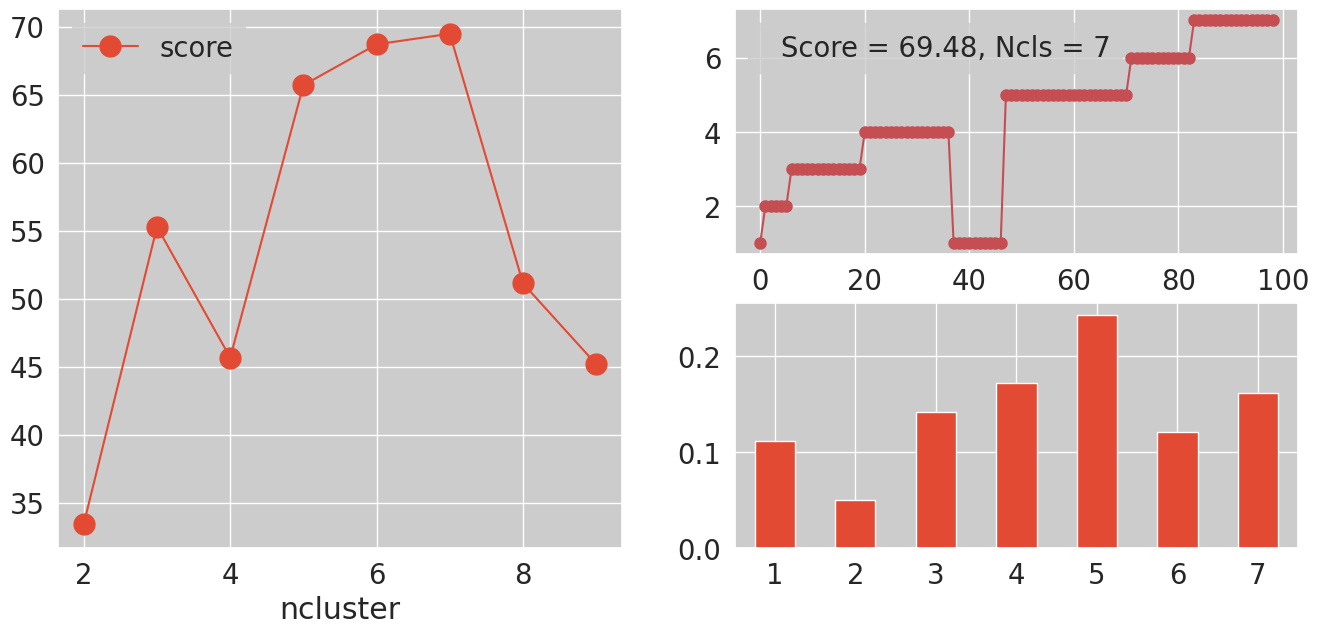

In [24]:
### find the top score parameter
idxPeak = score_KMediods['score'].idxmax();
ncls = score_KMediods.loc[idxPeak,'ncluster']
cl = KMedoids(n_clusters=ncls).fit_predict(Xys)
lab  = "Score = {:.2f}, Ncls = {:d}".format(evalute(Xys, cl), ncls)

### plot data
bt.plot.clplot(score_KMediods.set_index("ncluster"), cl, lab)

## Clustering by Spectral Clustering

### Spectral Clustering by Matrix

In [25]:
## Testing Spectral Clustering by matrix
def testSC(n):
    cl = SpectralClustering(n_clusters=n, affinity='precomputed').fit_predict(Smaty)
    return evalute (Xys, cl)

### get the score
score_SpectralMat = pd.DataFrame({'ncluster':np.arange(2,10)})
score_SpectralMat['score'] = score_SpectralMat['ncluster'].apply(testSC)

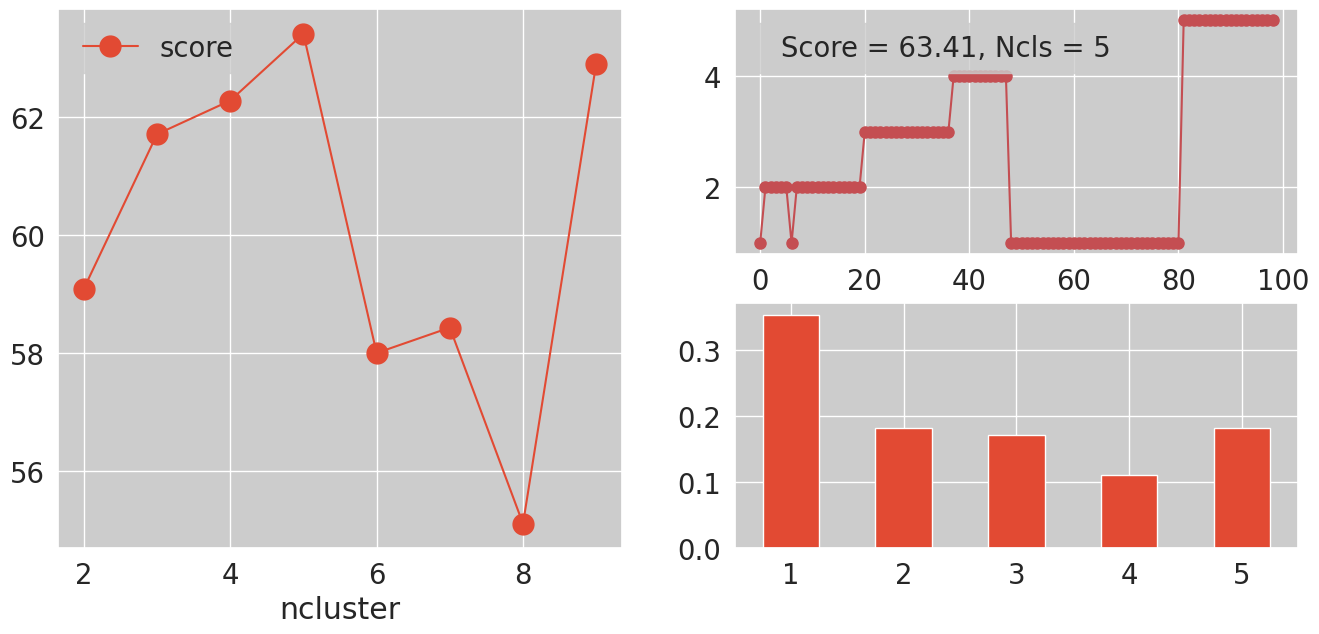

In [26]:
### find the top score parameter
idxPeak = score_SpectralMat['score'].idxmax();
ncls = score_SpectralMat.loc[idxPeak,'ncluster']
cl   = SpectralClustering(n_clusters=ncls, affinity='precomputed').fit_predict(Smaty)
lab  = "Score = {:.2f}, Ncls = {:d}".format(evalute (Xys, cl), ncls)

### plot data
bt.plot.clplot(score_SpectralMat.set_index("ncluster"), cl, lab)

### Spectral Clustering by Trajectory

In [27]:
score_Spectral = pd.DataFrame(columns=["gamma", "ncluster", "score"])
for gamma in [0.1, 0.5, 1, 2]:
    for ncls in np.arange(2,10):
        cl = SpectralClustering(n_clusters=ncls, gamma=gamma).fit_predict(Xys)
        score_Spectral.loc[len(score_Spectral.index)] = [gamma, ncls, evalute (Xys, cl)]

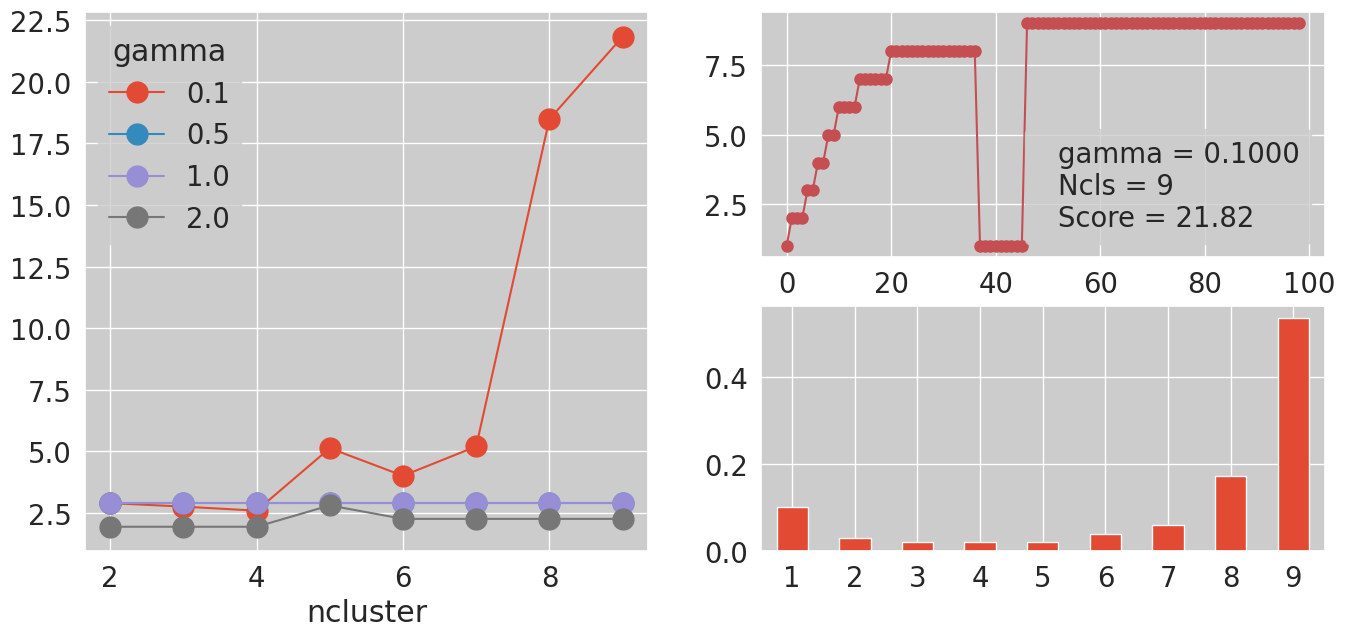

In [28]:
idxPeak = score_Spectral['score'].idxmax();
gamma   = score_Spectral.loc[idxPeak,"gamma"]
ncls    = score_Spectral.loc[idxPeak, "ncluster"].astype(int)
cl      = SpectralClustering(n_clusters=ncls, gamma=gamma).fit_predict(Xys)
lab     = "gamma = {:.4f}\nNcls = {:d}\nScore = {:.2f}"\
          .format(gamma, ncls, evalute (Xys, cl))

### plot data
bt.plot.clplot(score_Spectral.pivot(index='ncluster', 
                                    columns="gamma", 
                                    values="score"), cl, lab)

# Save Data

In [29]:
## save current ipynb
from ipylab import JupyterFrontEnd
app = JupyterFrontEnd()
app.commands.execute('docmanager:save')

In [30]:
## record output to pdf
#nbname = os.path.basename(app.sessions.get_state().get('current_session').get('path'))
nbname = 'EscalTM-multiTraj.ipynb'
srcpath = %pwd
srcfile = f"{srcpath}/{nbname}"


!jupyter nbconvert --to pdf --no-input --log-level 40 \
    --output-dir {datadir} --output f"EscalTM-multiTraj-{feature}.pdf" \
    {srcfile}